# Using Pyreal - Student Performance
---
In this demonstration, we will be working with the Student Performance Dataset[^1], which predicts the likelihood of students failing a class. We will be taking on the role of a **Pyreal User**, who is just looking to understand their model without a deep understanding of machine learning.

## Scenario Details
### Goals for this scenario
1. Learn how to use Pyreal to better understand your model and data
2. Learn how to generate and visualize interpretable explanations using Pyreal
3. Understand the contributions of the Pyreal library

### User Details
In this scenario, we will take on the following role:
- **User Role:** School district administrator
- **Expertise:**
    - **Domain (Education):** Expert
    - **Machine Learning:** Minimal
    - **Explainable ML techniques:** Minimal
- **User Goals:**
    1. Identify the risk factors associated with failing the class
    2. Identify students at risk of failure, and understand where this risk prediction comes from
    3. Identify which factors are associated with higher levels of success

### Model and Data Details
- 30 Features
- Predicts if student is expected to pass class (1 for pass, 0 for fail)

[^1]: P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.


## Data Preparation

We will begin by loading in a premade `RealApp` object for this scenario. This object was created by a `Pyeral Developer`, or another user with some understanding of machine learning. This may be the same person who originally trained our ML model.

We will also load in information about 10 students that we want to learn more about (students), and the training dataset (data), which we will use to better understand the model's historic prediction trends.

In [1]:
n_rows = 500

In [2]:
from pyreal.sample_applications import student_performance
from pyreal import visualize

real_app = student_performance.load_app(n_rows)
students = student_performance.load_students()
data, y = student_performance.load_data(n_rows)

students

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


,name,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,Jessica Gonzalez,GP,F,15,U,LE3,T,1,1,at_home,...,yes,yes,no,4,3,2,2,3,3,6
1,Lucia Thompson,GP,F,15,U,GT3,T,4,2,health,...,yes,yes,yes,3,2,2,1,1,5,0
2,Lincoln Bennet,GP,M,16,U,GT3,T,3,3,other,...,yes,no,no,4,3,2,1,2,5,0
3,Lily Perkins,MS,F,18,R,GT3,T,4,4,other,...,yes,yes,yes,3,2,2,4,2,5,0
4,Trevor Butler,GP,M,17,R,GT3,T,3,2,other,...,yes,yes,yes,4,4,4,1,4,3,4
5,Rebeca Guzman,MS,F,17,R,GT3,T,1,1,other,...,no,yes,no,5,4,4,2,2,5,0
6,Arianna Larson,MS,F,16,U,GT3,T,3,1,other,...,yes,yes,no,3,1,3,1,3,1,0
7,Alberto Luna,MS,M,16,U,GT3,T,3,2,services,...,yes,yes,no,3,1,3,1,4,3,2
8,Laura Tyler,MS,F,17,U,GT3,T,4,2,other,...,yes,yes,no,4,3,3,1,2,4,0
9,Adelyn Baker,MS,F,17,U,GT3,T,4,2,teacher,...,yes,yes,yes,4,2,3,3,1,5,0


## Goal 1: Understanding risk factors

Let's start by getting a general sense of what information the model thinks is most important for whether a student will pass or fail the class. We will start by generating a global explanation, that shows which features are overall most important.

Generating explanations using Pyreal is extremely easy, and they come out easily readable with no further effort. We just need to call the desired `produce()` function.

In this case, we will try `realApp.produce_feature_importance()`:

In [3]:
feature_importance = real_app.produce_feature_importance()
feature_importance

,Feature Name,Importance
Age,Age,0.137259
Family size,Family size,0.077579
Mother's education,Mother's education,0.092555
Father's education,Father's education,0.272704
Home to school travel time,Home to school travel time,0.114747
Weekly study time,Weekly study time,0.176336
Number of past class failures,Number of past class failures,1.123005
Extra education support,Extra education support,0.213939
Family eductional support,Family eductional support,0.052463
Extra paid classes within the subject,Extra paid classes within the subject,0.007059


As you can see, we get a DataFrame from this function that gives a relative importance score for each feature the model uses. This DataFrame is fully readable and ready to be plugged into the visualization tool of your choice. For this demo, we will use Pyreal's built-in visualization functions. The `plot_explanation` function will automatically choose a reasonable visualization function based on the given explanation.

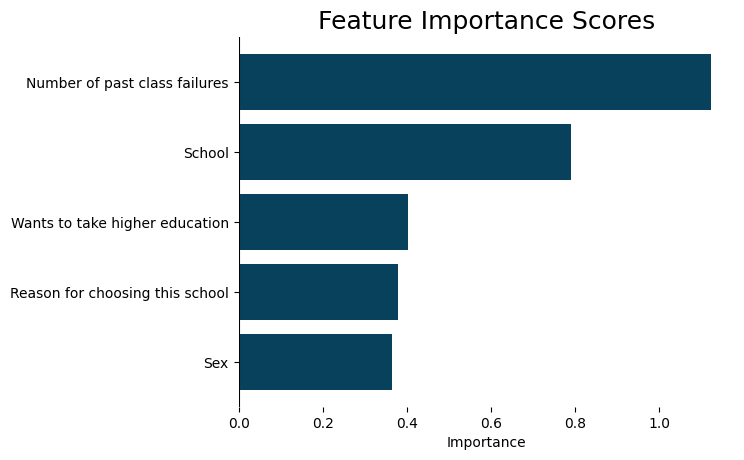

In [4]:
visualize.plot_explanation(feature_importance)

In the plot above, you can see the six features that the model considered most important. It looks like the number of past failures is highly predictive (makes sense!), as well as th school they attend and their reasons for choosing it.

We now have a rough sense of which features are important, but we want to understand this better. Which schools are more correlated with failure? Which reasons for choosing the school? Are male or female students predicted to struggle more in class?

To answer these questions, we can take a look at the feature contributions in individual cases on the dataset as a whole. Let's generate feature contribution predictions on the full historic dataset.

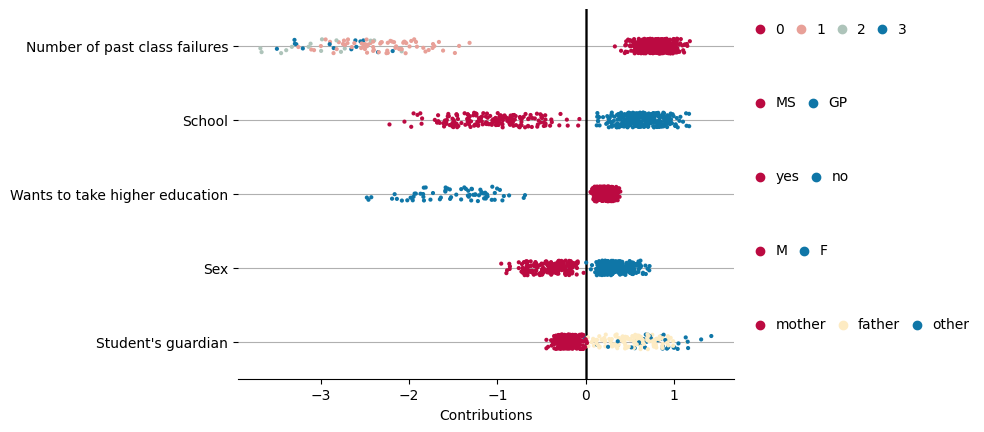

In [5]:
all_contributions = real_app.produce_feature_contributions(data)
visualize.plot_explanation(all_contributions, discrete=True, num_features=5)

The features in the swarm plot above are sorted by average contribution. Each dot represents a row in the dataset. Along the x-axis, we see how much each feature value contributed in each individual case.

We can see that having no past failures increases the prediction of passing the class (again, makes sense!). In the second row of the figure, we can see that attending school GP is correlated with passing the class, while MS reduces the model's prediction of passing. We can continue reading through the plot like this to better understand how our model considers its more important features.

Now, we (the school administrator) believe that attending class is extremely important for success, and we want to demonstrate that with past data. We can generate a plot to look just at contribution of this specific feature to the model prediction, to better highlight its correlation with success. 

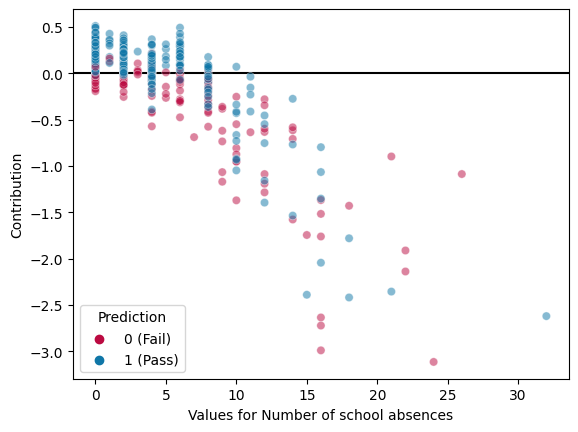

In [6]:
dataset_predictions = real_app.predict(data)

visualize.plot_explanation(all_contributions, feature="Number of school absences", predictions=dataset_predictions)

In the plot above, we can see a significant increase in predicted risk as number of absences passes about 5.

## Goal 2: Understanding students at risk

Now that we understand risk factors in general, let's take a look at some individual students at risk of failure.

We can begin by seeing which students our model believes are at risk of failure, using the `.predict()` function. This function handles all transformation needed to generate a model prediction. Here, a prediction of 0 means "failure", while a prediction of 1 means "no failure"

In [7]:
predictions = real_app.predict(students)
predictions

{'Jessica Gonzalez': '1 (Pass)',
 'Lucia Thompson': '1 (Pass)',
 'Lincoln Bennet': '1 (Pass)',
 'Lily Perkins': '0 (Fail)',
 'Trevor Butler': '0 (Fail)',
 'Rebeca Guzman': '0 (Fail)',
 'Arianna Larson': '0 (Fail)',
 'Alberto Luna': '0 (Fail)',
 'Laura Tyler': '1 (Pass)',
 'Adelyn Baker': '1 (Pass)',
 'Andre Kim': '1 (Pass)'}

Looks like five students are predicted to be at risk of failure. Let's take a closer look at Trevor Butler, to see where her prediction comes from. This RealApp is set up to have "name" as the row id column, so we can access the needed explanation with the name.

We can use more specific pyreal visualization functions to gain finer control. 

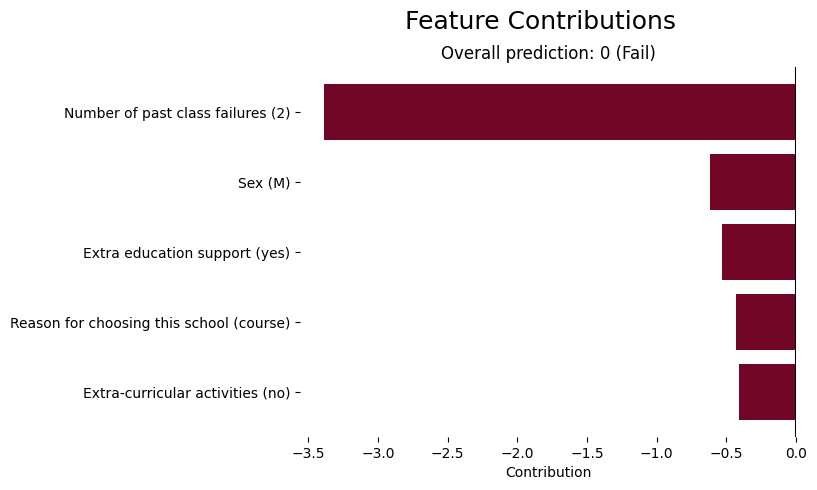

In [8]:
student_contributions = real_app.produce_feature_contributions(students)
visualize.feature_bar_plot(student_contributions["Trevor Butler"], prediction=predictions["Trevor Butler"])

We can see that Trevor's two past failures are greatly increasing his prediction towards failure. There is also a slight increase in risk for him being a male, receiving extra support, his lack of extra-curricular activities, and the fact that he chose the school do to course preference.

Let's take a look at another student, Arianna Larson:

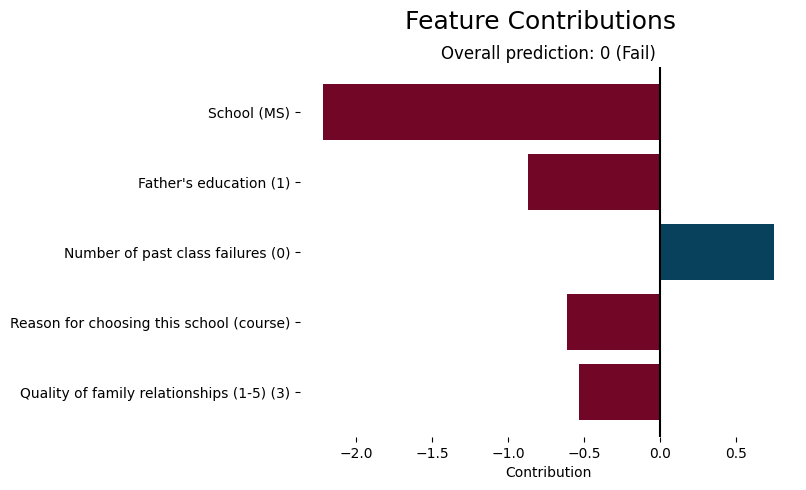

In [9]:
visualize.feature_bar_plot(student_contributions["Arianna Larson"], prediction=predictions["Arianna Larson"])

It looks like Arianna has never failed before, but her risk is greatly increasing due to her school. We can infer here that Arianna herself may benefit more from improvements to her school than personal extra attention.

To investigate further, we can look at three students that had similar factors to Arianna, and see what results they had.

In [10]:
similar_students = real_app.produce_similar_examples(students, standardize=True)

visualize.example_table(similar_students["Arianna Larson"], input_name="Arianna Larson")

,Ground Truth,School,Sex,Age,Address type,Family size,Parent's cohibition status,Mother's education,Father's education,Mother's job,...,Wants to take higher education,Has internet at home,In a romantic relationship,Quality of family relationships (1-5),Amount of free time after school (1-5),Frequency of going out with friends (1-5),Frequency of workday alcohol consumption (1-5),Frequency of weekend alcohol consumption (1-5),Current health status (1-5),Number of school absences
Arianna Larson,N/A,MS,F,16,U,GT3,T,3,1,other,...,yes,yes,no,3,1,3,1,3,1,0
12,0 (Fail),MS,F,16,U,GT3,T,3,1,other,...,yes,yes,no,3,1,3,1,3,1,0
485,1 (Pass),MS,F,16,U,GT3,T,2,1,other,...,yes,yes,no,5,3,3,1,1,1,0
70,0 (Fail),MS,F,17,R,GT3,T,1,2,other,...,yes,yes,no,3,5,5,1,3,1,4


## Goal 3: Identify factors associated with success

We have been told that Andre Kim is especially likely to pass according to the model, despite his attending the at-risk school, MS. Let's take a look at what factors are increasing his score, so we better understand what correlates with success:

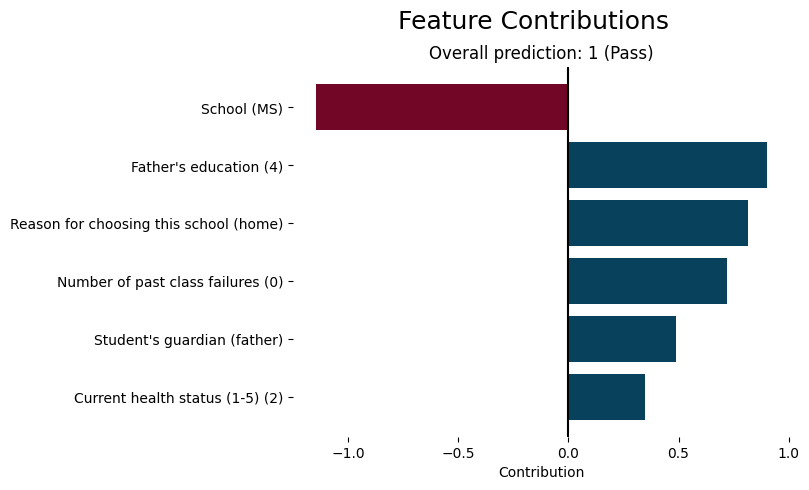

In [11]:
visualize.feature_bar_plot(student_contributions["Andre Kim"], num_features=6, prediction=predictions["Andre Kim"])

A highly educated father and no history of failures seem to be important here, as well as the fact that the student chose the school because it was close to their home .

## Comparison to existing methods

Pyreal is not the only library to offer these kinds of explanations, but it offers easier-to-use explanations without a deeper understanding of ML or XAI.

Let's compare the code required and explanation generated by another library, `shap`. With the code below, we are once again getting a local feature contributions explanation for Trevor Butler. For comparison, we repeat the Pyreal version of the explanation below.

Both explanations hold the same information, but you may find the Pyreal version quicker to parse, with significantly less required code.

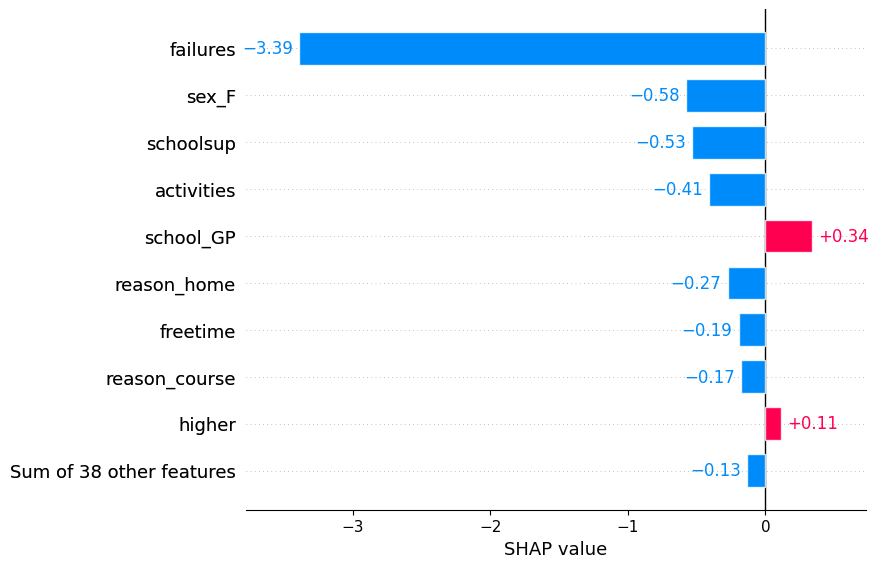

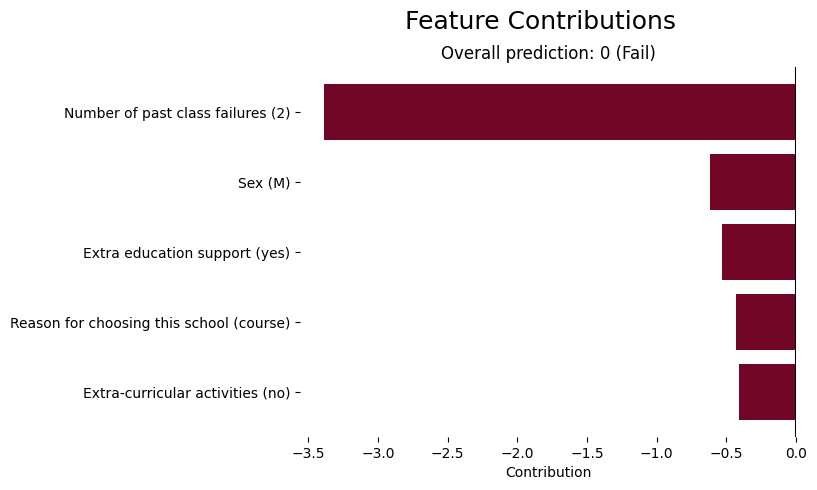

In [12]:
import shap

transformers = student_performance.load_transformers()
model = student_performance.load_model()
students_transformed = students.copy()
data_transformed = data.copy()
students_transformed = students_transformed.drop("name", axis="columns")
for transformer in transformers:
    students_transformed = transformer.transform(students_transformed)
    data_transformed = transformer.transform(data_transformed)

explainer = shap.TreeExplainer(model, data=data_transformed)

shap_values = explainer(students_transformed)
shap.plots.bar(shap_values[4]) # Trevor is row 4 in students

# Using Pyreal:
visualize.feature_bar_plot(student_contributions["Trevor Butler"], prediction=predictions["Trevor Butler"])
